<a href="https://colab.research.google.com/github/sora-12/Tobigs_music_project/blob/master/tobigs_style_transfer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from google.colab import drive
drive.mount("/content/gdrive",force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


# coco 2017 validation set

In [0]:
cd /root

/root


In [0]:
ll

total 0


In [0]:
mkdir coco

In [0]:
# 5000개
!wget http://images.cocodataset.org/zips/val2017.zip

--2019-07-18 11:01:49--  http://images.cocodataset.org/zips/val2017.zip
Resolving images.cocodataset.org (images.cocodataset.org)... 52.216.98.3
Connecting to images.cocodataset.org (images.cocodataset.org)|52.216.98.3|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 815585330 (778M) [application/zip]
Saving to: ‘val2017.zip’

val2017.zip         100%[===================>] 777.80M  13.7MB/s    in 59s     

2019-07-18 11:02:48 (13.2 MB/s) - ‘val2017.zip’ saved [815585330/815585330]



In [0]:
!unzip val2017.zip -d coco|

# chad's git clone

- https://github.com/Chad4545/styletransfer.git

In [0]:
cd /root

In [0]:
!git clone https://github.com/Chad4545/styletransfer.git

# style_images

In [0]:
from PIL import Image
import matplotlib.pyplot as plt

In [0]:
style_path ='/root/styletransfer/data/style_img/'
candy = Image.open(style_path+"candy.jpg",'r')
mosaic = Image.open(style_path+"mosaic.jpg",'r')
rain = Image.open(style_path+"rain-princess.jpg",'r')
sunset = Image.open(style_path+"sunset.jpg",'r')
udnie = Image.open(style_path+"udnie.jpg",'r')
vikendi = Image.open(style_path+"vikendi.jpg",'r')
sky = Image.open(style_path+"sky.jpg",'r')

cloudy = Image.open(style_path+"cloudy.JPG",'r')
desert = Image.open(style_path+"desert.JPG",'r')
neonsign = Image.open(style_path+"neonsign.JPG",'r')
sunlight = Image.open(style_path+"sunlight.JPG",'r')
sunset2 = Image.open(style_path+"sunset2.JPG",'r')


In [0]:
f, axarr = plt.subplots(2,3,figsize=(10,10))
axarr[0][0].imshow(cloudy)
axarr[0][1].imshow(desert)
axarr[0][2].imshow(neonsign)
axarr[1][0].imshow(sunlight)
axarr[1][1].imshow(sunset2)
axarr[1][2].imshow(sky)
plt.show()

In [0]:
cd /root/styletransfer

# import

In [0]:
import argparse
import os
import sys
import time

import numpy as np
import torch
from torch.optim import Adam
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision import transforms
import torch.onnx

import utils
from transformer_net import TransformerNet
from vgg import Vgg16

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

# parameter setting

In [0]:
cd /content/gdrive/My Drive/ImageProject

In [0]:
cd style_train_weight_box

In [0]:
ll


total 1261248
-rw------- 1 root 20179623 Jun 22 11:37 ckpt_epoch_0_batch_id_500.pth
-rw------- 1 root 20179627 Jun 22 12:40 ckpt_epoch_10_batch_id_500.pth
-rw------- 1 root 20179627 Jun 22 12:46 ckpt_epoch_11_batch_id_500.pth
-rw------- 1 root 20179629 Jun 22 12:52 ckpt_epoch_12_batch_id_500.pth
-rw------- 1 root 20179627 Jun 22 12:58 ckpt_epoch_13_batch_id_500.pth
-rw------- 1 root 20179629 Jun 22 13:05 ckpt_epoch_14_batch_id_500.pth
-rw------- 1 root 20179627 Jun 22 13:11 ckpt_epoch_15_batch_id_500.pth
-rw------- 1 root 20179625 Jun 22 13:17 ckpt_epoch_16_batch_id_500.pth
-rw------- 1 root 20179625 Jun 22 13:23 ckpt_epoch_17_batch_id_500.pth
-rw------- 1 root 20179627 Jun 22 13:29 ckpt_epoch_18_batch_id_500.pth
-rw------- 1 root 20179625 Jun 22 13:36 ckpt_epoch_19_batch_id_500.pth
-rw------- 1 root 20179623 Jun 22 11:44 ckpt_epoch_1_batch_id_500.pth
-rw------- 1 root 20179621 Jun 22 13:42 ckpt_epoch_20_batch_id_500.pth
-rw------- 1 root 20179619 Jun 22 13:48 ckpt_epoch_21_batch_id_50

In [0]:
rm ./*

In [0]:
ll

total 0


In [0]:
mkdir style_train_weight_box

mkdir: cannot create directory ‘style_train_weight_box’: File exists


In [0]:
batch_size = 8
random_seed = 10

num_epochs = 64 
initial_lr = 1e-3
# weight 저장
checkpoint_dir = "/content/gdrive/My Drive/ImageProject/style_train_weight_box/"


# 기존 이미지 
content_weight=1e5

# style image
style_weight=1e9
log_interval = 50

#몇번마다 저장할건지 
checkpoint_interval = 500


#running_option = "test"
running_option = "training"

# make dataloader

In [0]:
np.random.seed(random_seed)
torch.manual_seed(random_seed)

# for train_set
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(256),
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x.mul(255))
])

# for style_img
# 사이즈 상관 x
style_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x.mul(255))
])



train_dataset = datasets.ImageFolder("/root/coco", transform)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size)

transformer = TransformerNet().to(device)
optimizer = torch.optim.Adam(transformer.parameters(), initial_lr)
mse_loss = torch.nn.MSELoss()

# for style image

In [0]:
# for style_image

vgg = Vgg16(requires_grad=False).to(device)
style_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x.mul(255))
])


style = utils.load_image(filename=style_path+"sky.jpg", size=None, scale=None)
style = style_transform(style)
style = style.repeat(batch_size, 1, 1, 1).to(device)

features_style = vgg(utils.normalize_batch(style))
gram_style = [utils.gram_matrix(y) for y in features_style]

FileNotFoundError: ignored

# Training

In [0]:
transfer_learning = False # Inference or training first --> False / Transfer learning --> True
ckpt_model_path = os.path.join(checkpoint_dir, "ckpt_epoch_45_batch_id_500.pth") #FIXME

if transfer_learning:
    checkpoint = torch.load(ckpt_model_path, map_location=device)
    transformer.load_state_dict(checkpoint['state_dict'])
    transformer.to(device)




if running_option == "training":
    if transfer_learning:
        transfer_learning_epoch = checkpoint['epoch'] 
    else:
        transfer_learning_epoch = 0

    for epoch in range(transfer_learning_epoch, num_epochs):
        transformer.train()
        agg_content_loss = 0.
        agg_style_loss = 0.
        count = 0

        for batch_id, (x, _) in enumerate(train_loader):
            n_batch = len(x)
            count += n_batch
            optimizer.zero_grad()

            x = x.to(device)
            y = transformer(x).to(device)

            y = utils.normalize_batch(y)
            x = utils.normalize_batch(x)

            features_y = vgg(y)
            features_x = vgg(x)

            content_loss = content_weight * mse_loss(features_y.relu2_2, features_x.relu2_2)

            style_loss = 0.
            
            for ft_y, gm_s in zip(features_y, gram_style):
                gm_y = utils.gram_matrix(ft_y)
                style_loss += mse_loss(gm_y, gm_s[:n_batch, :, :])
            style_loss *= style_weight

            total_loss = content_loss + style_loss
            total_loss.backward()
            optimizer.step()

            agg_content_loss += content_loss.item()
            agg_style_loss += style_loss.item()

            if (batch_id + 1) % log_interval == 0:
                mesg = "{}\tEpoch {}:\t[{}/{}]\tcontent: {:.6f}\tstyle: {:.6f}\ttotal: {:.6f}".format(
                    time.ctime(), epoch + 1, count, len(train_dataset),
                                  agg_content_loss / (batch_id + 1),
                                  agg_style_loss / (batch_id + 1),
                                  (agg_content_loss + agg_style_loss) / (batch_id + 1)
                )
                print(mesg)

            if checkpoint_dir is not None and (batch_id + 1) % checkpoint_interval == 0:
                transformer.eval().cpu()
                ckpt_model_filename = "ckpt_epoch_" + str(epoch) + "_batch_id_" + str(batch_id + 1) + ".pth"
                print(str(epoch), "th checkpoint is saved!")
                ckpt_model_path = os.path.join(checkpoint_dir, ckpt_model_filename)
                torch.save({
                'epoch': epoch,
                'state_dict': transformer.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': total_loss
                }, ckpt_model_path)
                
                transformer.to(device).train() 
                
                
                
torch.save({
    'epoch': epoch,
    'state_dict': transformer.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'loss': total_loss}
    , '/content/gdrive/My Drive/ImageProject/weight_box/neonsignle9.pth')



Sun Jun 23 05:12:14 2019	Epoch 46:	[400/5000]	content: 72477.539531	style: 65609.980938	total: 138087.520469
Sun Jun 23 05:12:43 2019	Epoch 46:	[800/5000]	content: 72691.558555	style: 67113.093281	total: 139804.651836
Sun Jun 23 05:13:13 2019	Epoch 46:	[1200/5000]	content: 72447.936875	style: 67330.138932	total: 139778.075807
Sun Jun 23 05:13:43 2019	Epoch 46:	[1600/5000]	content: 73094.224980	style: 67604.408594	total: 140698.633574
Sun Jun 23 05:14:12 2019	Epoch 46:	[2000/5000]	content: 72824.719500	style: 67416.100969	total: 140240.820469
Sun Jun 23 05:14:42 2019	Epoch 46:	[2400/5000]	content: 73088.931458	style: 67429.337904	total: 140518.269362
Sun Jun 23 05:15:12 2019	Epoch 46:	[2800/5000]	content: 73298.978672	style: 67519.392054	total: 140818.370725
Sun Jun 23 05:15:41 2019	Epoch 46:	[3200/5000]	content: 73010.711348	style: 67435.234414	total: 140445.945762
Sun Jun 23 05:16:11 2019	Epoch 46:	[3600/5000]	content: 72842.669661	style: 67378.970929	total: 140221.640590
Sun Jun 23 0

" torch.save({\n     'epoch': epoch,\n     'state_dict': transformer.state_dict(),\n     'optimizer_state_dict': optimizer.state_dict(),\n     'loss': total_loss}\n     , '/root/styletransfer/data/pretrained/sunlightle8.pth')\n\n\n"

'/content/gdrive/My Drive/ImageProject/style_train_weight_box/ckpt_epoch_63_batch_id_500.pth'

In [0]:
ckpt_model_path

'/content/gdrive/My Drive/ImageProject/weight_box/sunlightle9.pth'

# Inference


In [0]:


running_option = "test"
#running_option = "training"


transfer_learning = True# inference or training first --> False / Transfer learning --> True



   

'''
candy,  mosaic, rain_princess, udnie, sky, sunset 

cloudy,desert,neonsign,sunlight,sunset2 



'''
which_style = "sky"
#pretrain_path ='/content/gdrive/My Drive/ImageProject/weight_box/'
pretrain_path = '/root/styletransfer/data/pretrained/'
ckpt_model_path = pretrain_path + which_style + '.pth'
ckpt_model_path


if transfer_learning:
    checkpoint = torch.load(ckpt_model_path, map_location=device)
    transformer.load_state_dict(checkpoint['state_dict'])
    transformer.to(device)



In [0]:
import glob
test_img=glob.glob("/root/styletransfer/data/content_img/*.jpg")
test_img[2]

'/root/styletransfer/data/content_img/bed1.jpg'

In [0]:
cd /root

/root


In [0]:
mkdir result

In [0]:
import re

In [0]:
if running_option == "test":
    content_image = utils.load_image(test_img[1])
    print(test_img[1])
    content_transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Lambda(lambda x: x.mul(255))
    ])
    content_image = content_transform(content_image)
    content_image = content_image.unsqueeze(0).to(device)

    with torch.no_grad():
        style_model = TransformerNet()
        
        pre_train = ckpt_model_path
        #pre_train = "/content/gdrive/My Drive/imageProject/style_transformation/dataset/sky.pth"
        print(pre_train)
        checkpoint = torch.load(pre_train, map_location=device)
        #print(checkpoint)
        # remove saved deprecated running_* keys in InstanceNorm from the checkpoint
        for k in list(checkpoint.keys()):
            if re.search(r'in\d+\.running_(mean|var)$', k):
                del checkpoint[k]
        

        
        style_model.load_state_dict(checkpoint['state_dict'])
        style_model.to(device)
        
        output = style_model(content_image).cpu()
        
    utils.save_image("/root/result/"+which_style+"_result0.jpg", output[0]) #FIXME
    

/root/styletransfer/data/content_img/bed2.jpg
/root/styletransfer/data/pretrained/sky.pth


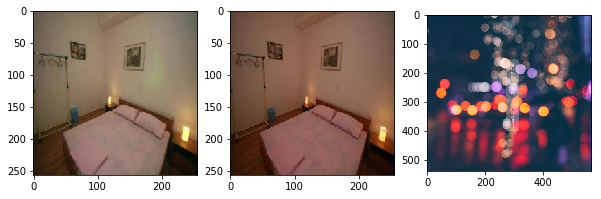

In [0]:
result = Image.open("/root/result/"+which_style+'_result0.jpg')
input_img = Image.open("/root/styletransfer/data/content_img/bed2.jpg")
f, axarr = plt.subplots(1,3,figsize=(10,10))
axarr[0].imshow(result)
axarr[1].imshow(input_img)
axarr[2].imshow(neonsign)
                


plt.show()